# Transformer

## Introduction

The Transformer architecture has transformed the landscape of *natural language processing (NLP)* and is rapidly extending its reach into other domains. Its groundbreaking innovation, the self-attention mechanism, empowers models to directly grasp relationships between elements of a sequence, regardless of their distance. This overcomes the limitations of traditional recurrent neural networks (RNNs) in handling long-range dependencies. The Transformer's success has propelled breakthroughs in machine translation, text summarization, and numerous other NLP tasks.

### Motivation: Why Look Beyond RNNs?

Recurrent neural networks (RNNs) process sequences one element at a time, relying on a hidden state to carry information forward. While theoretically capable of handling long-range dependencies, RNNs often falter in practice due to:

- **Vanishing and Exploding Gradients:** These issues during backpropagation make it difficult for the model to learn long-term relationships within sequences.

- **Sequential Processing:** The step-by-step nature of RNNs inhibits parallelization, leading to longer training times.

- **Fixed-length Hidden State:** The limited capacity of the hidden state can result in information loss, especially when dealing with very long sequences.

### The Power of Attention
The attention mechanism provides a solution. Imagine having direct access to a database where you can query for specific information – that's the essence of how attention functions within the Transformer. It enables the model to selectively focus on the most relevant parts of the input sequence for each prediction, establishing "shortcuts" across the sequence. This ability is reminiscent of how humans selectively attend to information during processing.

## What is Attention 

At its core, attention is a mechanism within neural networks that mimics  how humans selectively focus on specific parts of their input.  In the context of the Transformer, imagine the attention mechanism working like this:

- **The Database:** You have a database of information, where each entry consists of a key-value pair.

- **The Query:** You have a query you want to find relevant information for.

- **The Attention Process:** The attention mechanism compares your query to all the keys in the database. It calculates an *"attention weight"* for each key, which signifies how strongly that key is related to your query. Finally, it produces a weighted combination of the values, with higher weights given to values associated with keys more relevant to the query.

Consider a database $\mathcal{D}$ comprising pairs of keys and values, denoted as $\mathcal{D} = \lbrace({\bf k}_1, {\bf v}_1), \cdots, ({\bf k}_m, {\bf v}_m)\rbrace$, and a query vector ${\bf q}$. The $Attention$ function over database $\mathcal{D}$ is defined as follows:

$$
Attention({\bf q}, \mathcal{D}) = \sum_{i=1}^m \alpha({\bf q}, {\bf k}_i) {\bf v}_i
$$

where  $\alpha$ is a function that outputs a real-valued scalar known as the attention weight.

This function quantitatively determines the relevance of each key ${\bf k}_i$ to the query ${\bf q}$. The attention mechanism essentially aggregates the values ${\bf v}_i$ in the database $\mathcal{D}$, weighted by the relevance (or attention) scores calculated by $\alpha$. This process encapsulates the core idea behind attention: allocating focus proportionally based on the compatibility between the query ${\bf q}$ and each key ${\bf k}$ in the database.

### Choices of Attention Weight

When selecting the function $\alpha$, commonly used options are:

$$
\begin{align*}
\alpha(\mathbf{q}, \mathbf{k}) &= \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2\right) & \text{(Gaussian)} \\
\alpha(\mathbf{q}, \mathbf{k}) &= 
    \begin{cases} 
    1 & \text{if } \|\mathbf{q} - \mathbf{k}\| \leq 1 \\
    0 & \text{otherwise}
    \end{cases}
    & \text{(Boxcar)} \\
\alpha(\mathbf{q}, \mathbf{k}) &= \max(0, 1-\|\mathbf{q} - \mathbf{k}\|) & \text{(Epanechikov)}
\end{align*}
$$

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import datetime as dt
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pybit.unified_trading import HTTP
import time 

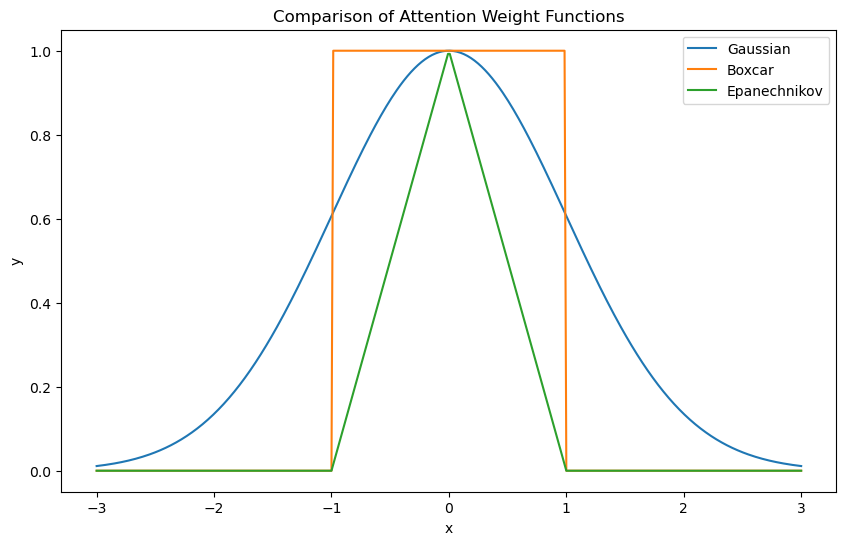

In [21]:
# Define the functions
def gaussian(x):
    return np.exp(-x**2 / 2)
def boxcar(x):
    return np.abs(x) < 1.0
def epanechikov(x):
    return np.maximum(1 - np.abs(x), np.zeros_like(x))
# Generate x values
x_values = np.linspace(-3, 3, 400)
# Generate y values for each function
y_gaussian = gaussian(x_values)
y_boxcar = boxcar(x_values)
y_epanechikov = epanechikov(x_values)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_gaussian, label='Gaussian')
plt.plot(x_values, y_boxcar, label='Boxcar')
plt.plot(x_values, y_epanechikov, label='Epanechnikov')
plt.title('Comparison of Attention Weight Functions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


### The Challenge of Computational Cost

These traditional attention functions suffer from computational inefficiency when dealing with  high-dimensional data.

### Solution: Scaled Dot Product Attention Weight

Examining the Gaussian Attention function without exponentiation reveals:

$$
\alpha'(\mathbf{q}, \mathbf{k}_i) = \frac{-1}{2} \|\mathbf{q} - \mathbf{k}_i\|^2 = \mathbf{q}^\mathsf{T} \mathbf{k}_i - \frac{1}{2} \|\mathbf{k}_i\|^2 - \frac{1}{2} \|\mathbf{q}\|^2
$$

Note that:

- The term $\frac{1}{2} \lVert {{\bf q}} \rVert^2$ is dependent solely on ${\bf q}$ and remains constant across all $({\bf q}, {\bf k}_i)$ pairs. When normalizing the attention weights to sum to 1, this term is effectively negated.

- The term $\frac{1}{2} \|\mathbf{k}_i\|^2$ can be omitted from the definition of $\alpha$ with minimal impact on the result. This is permissible because layer normalization results in well-bounded activations, and the keys $\mathbf{k}_i$ are often generated via a layer norm.

- To maintain control over the magnitude of arguments in the exponential function, the dot product is scaled by $1/\sqrt{d}$, where $d$ is the dimensionality of the key vector $\mathbf{k}_i$.

Thus, we arrive at the simplified and efficient form:

$$
\alpha'(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\mathsf{T} \mathbf{k}_i}{\sqrt{d}}
$$

Following this, applying the softmax function for normalization gives us:

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{Softmax}\left(\frac{\mathbf{q}^\mathsf{T} \mathbf{k}_i}{\sqrt{d}}\right) = \frac{\exp\left( \frac{\mathbf{q}^\mathsf{T} \mathbf{k}_i}{\sqrt{d}} \right)}{\sum_{j=1}^{m} \exp\left( \frac{\mathbf{q}^\mathsf{T} \mathbf{k}_j}{\sqrt{d}} \right)}
$$

## Self-Attention 

At its heart, self-attention enables a Transformer model to understand how different parts of its input sequence relate to each other. Here's how it works:

### Architecture

$$
\text{Attention}(Q,K,V) = \text{Softmax}(\frac{Q K^T}{\sqrt{d}})V
$$

<p align="center">
  <img src="photo//Transformer/self-attention.png" width="80%">
</p>

1. **Construction of Queries, Keys and Values**

    Using the weight matrices operates on input vectors to construct $n$ queries, keys and values.

    $$
    \begin{align*}
    {\bf q}_i &= W_q {\bf x}_i
    \\
    {\bf k}_i &= W_k {\bf x}_i
    \\
    {\bf v}_i &= W_v {\bf x}_i
    \end{align*}
    $$

2. **Calculating Attention**

    For each ${\bf q}_i$ calculate the Attention with $\mathcal{D} = \lbrace({\bf k}_1,{\bf v}_1), \cdots, ({\bf k}_n,{\bf v}_n)\rbrace$

    $$
    \text{Attention}({\bf q}_i, \mathcal{D}) = \sum_{j=1}^{n}\text{Softmax}(\frac{{\bf q}_i {\bf k}_{j}^{T}}{\sqrt{d}}){\bf v}_j
    $$
    

where:

- ${\bf x}_i$ is the  $i$-th input vector.
- ${\bf q}_i, {\bf k}_i, {\bf v}_i$ is query, key, value of ${\bf x}_i$ respectively.
- $W_q, W_k, W_v$ are weight matrices that are learned during training.
- $d$ is the dimension of ${\bf k}_j$

### Remark

If we put the vectors into a matrix as $Q = ({\bf q}_i)$, $K = ({\bf k}_i)$, $V = ({\bf v}_i)$, then the Attention can be written as:

$$
\text{Attention}(Q,K,V) := \text{Attention}(Q,\mathcal{D}) = \text{Softmax}(\frac{Q K^T}{\sqrt{d}})V = \big(\text{Attention}({\bf q}_i,\mathcal{D})\big)
$$

### Why Self-Attention? 

1. **Long-Range Dependencies**

    Self-attention allows models to directly compute relationships between any two positions in the input sequence, regardless of their distance. This capability is particularly beneficial for complex relationships in data.

2. **Parallelization** 

    Unlike RNNs and LSTMs, which process data sequentially, self-attention processes all positions in the input simultaneously. This characteristic significantly reduces training times since it leverages the parallel processing capabilities of modern GPUs more efficiently.


## Multi-Head Attention

### Motivation

In certain scenarios, when presented with an identical set of queries, keys, and values, it may be advantageous for our model to merge insights from varied manifestations of the same attention mechanism. This approach aims to recognize and incorporate dependencies across multiple ranges within a sequence—for instance, distinguishing between short-range and long-range interactions. Therefore, enabling our attention mechanism to simultaneously utilize diverse representation subspaces for queries, keys, and values could enhance its capability to capture a broad spectrum of relationships within the data.

### Architecture

Instead of performing a single attention function with $d$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_{k}$, $d_{k}$ and $d_{v}$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_{v}$-dimensional output values.

$$
\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, \cdots, \text{head}_n)W^O
$$

where

$$
\text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i)
$$

<p align="center">
  <img src="photo//Transformer/Multi-head attention.png" width="80%">
</p>

1. **Construction of Queries, Keys and Values**

    Using the weight matrices operates on input vectors to construct $n$ queries, keys and values.

    $$
    \begin{align*}
    {\bf q}_i &= W_q {\bf x}_i
    \\
    {\bf k}_i &= W_k {\bf x}_i
    \\
    {\bf v}_i &= W_v {\bf x}_i
    \end{align*}
    $$

2. **Construction of Subqueries, Subkeys and Subvalues**

    Using the weight matrices operates on queries, keys and values to construct $m$ Subqueries, Subkeys and Subvalues respectively.

    $$
    \begin{align*}
    {\bf q}_{ij} &= W^Q_j {\bf q}_i
    \\
    {\bf k}_{ij} &= W^K_j {\bf k}_i
    \\
    {\bf v}_{ij} &= W^V_j {\bf v}_i
    \end{align*}
    $$

3. **Attention**

    For each ${\bf q}_{ij}$ calculate the Attention with $\mathcal{D}_j = \lbrace({\bf k}_{1j},{\bf v}_{1j}), \cdots, ({\bf k}_{nj},{\bf v}_{nj})\rbrace$.

    $$
    \text{head}_{ij} = \text{Attention}({\bf q}_{ij}, \mathcal{D}_j) = \sum_{k=1}^{n}\text{Softmax}(\frac{{\bf q}_{ij} {\bf k}_{kj}^{T}}{\sqrt{d_j}}){\bf v}_{kj}
    $$

4. **Concatation of Heads**

    Concat the Attention of each heads, and multiply with a weight matrix, $\mathcal{D} = \lbrace({\bf k}_{1},{\bf v}_{1}), \cdots, ({\bf k}_{n},{\bf v}_{n})\rbrace$..

    $$
    \text{MultiHead}({\bf q}_i, \mathcal{D}) = \text{Concat}(\text{head}_{i1}, \cdots, \text{head}_{im})W^O
    $$

where:

- ${\bf x}_i$ are the  $i$-th input vector.
- ${\bf q}_i, {\bf k}_i, {\bf v}_i$ are query, key, value of ${\bf x}_i$ respectively.
- ${\bf q}_{ij}, {\bf k}_{ij}, {\bf v}_{ij}$ is the subquery of ${\bf q}_i$, subkey of ${\bf k}_i$, subvalue of ${\bf v}_i$ respectively.
- $W$ terms represent weight matrices (e.g., $W_q$, $W_k$, $W_v$) that are learned during training.
- $d_j$ is the dimension of ${\bf k}_{ij}$

### Remark

If we put the vectors into a matrix as $Q = ({\bf q}_i)$, $K = ({\bf k}_i)$, $V = ({\bf v}_i)$ in columns and $\text{head}_i = (\text{head}_{ij})$ in rows, then the Multi-Attention can be written as:

$$
\text{MultiHead}(Q,K,V) := \text{MultiHead}(Q, \mathcal{D}) = \text{Concat}(\text{head}_1, \cdots, \text{head}_m)W^O = \big(\text{MultiHead}({\bf q}_i, \mathcal{D})\big)
$$

where

$$
\text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i)
$$

## Difference Between Self-Attention And Multi-Head Attention

The key distinction lies in their processing capacity and perspective. Multi-head attention, with its multiple sets of attention mechanisms, can explore and capture the complexity of data in a more nuanced way than self-attention, which operates with a single attention mechanism. This makes multi-head attention more effective at understanding and representing the multifaceted relationships and dependencies within data, particularly for complex sequences where different elements may have varying degrees of relevance to each other.

**Self-Attention**

- **Single Perspective**

    It calculates the attention scores based on a single set of query, key, and value vectors. This mechanism enables each element in the sequence to attend to every other element, capturing relationships within a singular representational space.

- **Purpose**

    Self-attention aims to understand the context and dependencies of each element in the sequence with respect to the whole sequence, but it does 
    so from a singular perspective.

**Multi-Head Attention**

- **Multiple Perspectives**

    It extends self-attention by introducing multiple sets of query, key, and value vectors, known as "heads." Each head can potentially focus on different parts of the sequence, allowing the model to capture various aspects of the information.

- **Enhanced Capacity**

    By having multiple attention mechanisms operate in parallel, multi-head attention can capture a more diverse set of relationships and features within the sequence. This is particularly useful for complex tasks that benefit from understanding the sequence from multiple representational subspaces.


## Cross Attention

### Motivation

Cross-attention mechanisms are crucial in many machine learning models, particularly those involved in tasks that require understanding and integrating information from two or more distinct data sources.
For instance, In the Transformer model, the output of the model is used to be the input of next time step, hence the query is obtained from the **Decoder** and the key, value is obtained from **Encoder**.

**Flexibility and Adaptability**: 

Cross-attention mechanisms allow models to adaptively focus on the most relevant information from one data source when processing another. This adaptability is especially valuable in processing sequences of varying lengths and complexities, where the relevance of different parts of the input can change dramatically from one instance to the next.

**Scalability to Long Sequences**: 

Traditional attention mechanisms can struggle with long sequences due to computational constraints and the dilution of attention scores. Cross-attention, by focusing attention more selectively, can mitigate these issues, making it easier to scale models to handle longer inputs effectively.

### Architecture

<p align="center">
  <img src="photo//Transformer/cross-attention.png" width="80%">
</p>

1. **Construction of Queries, Keys and Values**

    Using the weight matrices operates on input vectors to construct $n$ queries, keys and values.

    $$
    \begin{align*}
    {\bf q}_i &= W_q {\bf x}_{\text{Decoder},(i)}
    \\
    {\bf k}_i &= W_k {\bf x}_{\text{Encoder},(i)}
    \\
    {\bf v}_i &= W_v {\bf x}_{\text{Encoder},(i)}
    \end{align*}
    $$

2. **Final Output**

    We may choose the **Self-Attention** or **Multi_Head Attention** as the final output.

where

- ${\bf q}_i, {\bf k}_i, {\bf v}_i$ are query, key, value of ${\bf x}_{\text{Decoder},(i)}$ respectively.
- $W$ terms represent weight matrices (e.g., $W_q$, $W_k$, $W_v$) that are learned during training.

## Masking

### Motivation

Masked attention, particularly in the context of machine learning models like Transformers, is crucial for handling tasks where the model's predictions should not be influenced by future input information.

**Padding:** 

Sequences are often padded to ensure that all inputs in a batch have the same length. Masks are used to tell the model to ignore these padding elements, preventing them from affecting the computation.

**Future Information:** 

In tasks where the future input should not influence the prediction (like forecasting or generating text one token at a time), masks ensure that the model only focuses on past and current inputs.

### Architecture

### Masked Attention

<p align="center">
  <img src="photo//Transformer/Masking.png" width="50%">
</p>

1. **Construction of Queries, Keys and Values**

    Using the weight matrices operates on input vectors to construct $n$ queries, keys and values.

    $$
    \begin{align*}
    {\bf q}_i &= W_q {\bf x}_i
    \\
    {\bf k}_i &= W_k {\bf x}_i
    \\
    {\bf v}_i &= W_v {\bf x}_i
    \end{align*}
    $$

2. **Attention**

    Given time step $t$:

    The output $Y_t$ only depends on $X_i$ where $i \leq t$, to prevent considering the future information.

    $$
    Y_t = \text{Attention}({\bf q}_t, \mathcal{D}_t)
    $$

where

- $\mathcal{D}_t = \{ ({\bf k}_1, {\bf v}_1), \cdots, ({\bf k}_t, {\bf v}_t) \}$
- ${\bf q}_i, {\bf k}_i, {\bf v}_i$ are query, key, value of ${\bf x}_i$ respectively.
- $W$ terms represent weight matrices (e.g., $W_q$, $W_k$, $W_v$) that are learned during training.


### Remark

A mathematical technique can be employed to compute Masked Attention more efficiently. Represent the matrices $Q$, $K$, and $V$ as follows:

$$
Q
=
\begin{bmatrix}
\mathbf{q}_1 \\
\mathbf{q}_2 \\
\vdots \\
\mathbf{q}_T
\end{bmatrix}, \quad
K
=
\begin{bmatrix}
\mathbf{k}_1 \\
\mathbf{k}_2 \\
\vdots \\
\mathbf{k}_T
\end{bmatrix}, \quad
V
= 
\begin{bmatrix}
\mathbf{v}_1 \\
\mathbf{v}_2 \\
\vdots \\
\mathbf{v}_T
\end{bmatrix}
$$

The weight matrix $W = \text{Softmax}\left(\frac{QK^T}{\sqrt{d}}\right)$ is structured as:

$$
W 
= 
\begin{bmatrix}
w_{11} & w_{12} & \cdots & w_{1T} \\
w_{21} & w_{22} & \cdots & w_{2T} \\
\vdots & \vdots & \ddots & \vdots \\
w_{T1} & w_{T2} & \cdots & w_{TT}
\end{bmatrix}
$$

where each element $w_{ij}$ is derived from $\mathbf{q}_i$ and $\mathbf{k}_j$.

To prevent incorporating future information in the calculation of attention, we need $W$ to be upper triangular:

$$
W 
=
\begin{bmatrix}
w_{11} & 0 & \cdots & 0\\
w_{21} & w_{22} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
w_{(T-1)1} & w_{(T-1)2} & \cdots & 0\\
w_{T1} & w_{T2} & \cdots & w_{TT}
\end{bmatrix}
$$

Consequently, the attention operation is:

$$
\text{Attention}(Q, K, V)
=
WV
=
\begin{bmatrix}
w_{11} & 0 & \cdots & 0\\
w_{21} & w_{22} & \cdots & 0\\
\vdots & \vdots & \vdots & \vdots\\
w_{T-1,1} & w_{T-1,2} & \cdots & 0\\
w_{T1} & w_{T2} & \cdots & w_{TT}
\end{bmatrix}
\begin{bmatrix}
\mathbf{v}_1 \\
\mathbf{v}_2 \\
\vdots \\
\mathbf{v}_T
\end{bmatrix}
=
\begin{bmatrix}
w_{11} \mathbf{v}_1 \\
w_{21} \mathbf{v}_1 + w_{22} \mathbf{v}_2 \\
\vdots \\
\sum_{j=1}^{T} w_{Tj} \mathbf{v}_j
\end{bmatrix}
$$

Equivalentally, we introduce a mask matrix $M$ before applying the softmax:

$$
M 
=
\begin{bmatrix}
0 & -\infty & \cdots & -\infty \\
0 & 0 & \cdots & -\infty \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0
\end{bmatrix}
$$

**Result:**

The Masked-Attention is then given by:

$$
\text{Masked-Attention}(Q, K, V)
= 
\text{Softmax}\left(\frac{QK^T}{\sqrt{d}} + M\right)
$$

where $M$ ensures that the softmax operation does not consider future tokens, thus preserving the intended information flow in models such as transformers.



## Example: The Nonlinear Autoregressive Exogenous (NARX) MODEL

### Problem Statement
The NARX model aims to predict future values of a target time series given its own past values and the values of related external (exogenous) time series.  Here's the formal setup:

- **Driving Series:** We have $n$ driving series, represented as $X = (x^1, x^2, \ldots, x^n)^T$. Each $x^k$ has length $T$ (the window size).

- **Target Series:** Our goal is to predict future values of the target series $(y_1, y_2, \ldots, y_T)$.

- **Inputs:** At time $t$, we have access to the input vector $x_t = (x_t^1, x_t^2, \ldots, x_t^n)^T$ and past target values.

- **Output:** The model predicts $y_{T+1}$.

- **Function:** NARX learns a nonlinear mapping $\hat{y}_{T+1} = F(y_1, \ldots, y_T, x_1, \ldots, x_T)$ to make its predictions.

**Key Idea:** NARX selectively focuses on certain parts of the input data at different time steps. This selective attention helps it handle complexities and dependencies within the time series.

### Architecture

<p align="center">
<img src="photo/Transformer/NARX.png" width="80%">
</p>

### Encoder

- **Attention**

    The encoder employs an input attention mechanism, allowing the model to selectively focus on different input features at each time step.

    $$
    \begin{align*}
    e_t^k &= v_e^T \tanh(W_e [h_{t-1}; s_{t-1}] + U_e x^k)
    \\
    \alpha_t^k &= \frac{\exp(e_t^k)}{\sum_{i=1}^n \exp(e_t^i)}
    \end{align*}
    $$

    where 
    
    - $h_{t-1}, s_{t-1}$  are the previous hidden state and cell state of the LSTM unit respectivly.
    - $v_e \in \mathbb{R}^T$, $W_e \in \mathbb{R}^{T \times 2m}$ and $U_e \in \mathbb{R}^{T \times T}$ are parameters to learn.
    
    $\alpha_t^k$ is the attention weight measuring the importance of the $k$-th input feature (driving series) at time $t$.

- **LSTM**

    With the proposed input attention mechanism, the encoder can selectively focus on certain driving series rather than treating all the input driving series equally.

    $$
    \tilde{x}_t = (\alpha_t^1 x_t^1, \alpha_t^2 x_t^2, \ldots, \alpha_t^n x_t^n)^T
    $$

    The hidden state at time $t$ can be updated as:

    $$
    h_{t} = \text{LSTM}_1(h_{t-1}, \tilde{x}_t)
    $$


### Decoder

- **Attention**

    After processing the inputs, the decoder uses another form of attention (temporal attention) to focus on different time steps of the encoder's output:

    $$
    \begin{align*}
    l_t^i &= v_d^T \tanh(W_d[d_{t-1}; s'_{t-1}] + U_d h_i), \quad 1 \leq i \leq T
    \\
    \beta_t^i &= \frac{\exp(l_t^i)}{\sum_{j=1}^T \exp(l_t^j)}
    \end{align*}
    $$

    where 
    
    - $d_{t-1}, s'_{t-1}$ are the previous hidden state and cell state of the LSTM unit respectivly.
    - $v_d \in \mathbb{R}^m$, $W_d \in \mathbb{R}^{m \times 2p}$ and $U_d \in \mathbb{R}^{m \times m}$ are parameters to learn.

    The attention weight $\beta_t^i$ represents the importance of the $i$-th encoder hidden state for the prediction.


- **LSTM**

    The decoder's LSTM unit uses the context vector $c_t$, which is a weighted sum of the encoder's hidden states, combined with the target series $y_{t}$, to update the decoder's hidden state $d_t$.

    This mechanism allows the decoder to effectively integrate information across all past time steps, focusing on the most relevant outputs to generate predictions.
    
    $$
    \begin{align*}
    c_t &= \sum_{i=1}^T \beta_t^i h_i.
    \\
    \tilde{y}_{t} &= \tilde{w}^T [y_{t}; c_{t}] + \tilde{b}
    \end{align*}
    $$
    
    where 
    
    - $y_{t}, c_{t}$  are the decoder input and the computed context vector respectively
    - $\tilde{w} \in \mathbb{R}^{m+1}$ and $\tilde{b} \in \mathbb{R}$ are parameters to learn.
    
    The newly computed $\tilde{y}_{t-1}$ can be used for the update of the decoder hidden state at time $t$:

    $$
    d_t = \text{LSTM}_2(d_{t-1}, \tilde{y}_{t}).
    $$


- **Prediction**

    The final step in the decoder uses the last hidden state of the decoder and the context vector to predict the next value in the series.

    $$
    \hat{y}_T = v_y^T (W_y [d_T; c_T] + b_w) + b_v,
    $$
    
    where 
    
    - $d_T, c_T$ are the decoder hidden state and the context vector of time step $T$.
    - $W_y \in \mathbb{R}^{p \times (p+m)}$, $v_y \in \mathbb{R}^p$, $b_w \in \mathbb{R}^p$ and $b_v \in \mathbb{R}$ are parameters to learn.



## Code Implementation

## Model Construction

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, T):
        # input size: number of underlying factors
        # T: number of time steps (10)
        # hidden_size: dimension of the hidden state
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.T = T
        self.n = input_size
        self.lstm1= nn.LSTMCell(input_size=self.n, hidden_size=self.hidden_size).to(device)
        self.attnWe = nn.Linear(in_features = 2 * hidden_size, out_features = T, bias=False).to(device)
        self.attnUe = nn.Linear(in_features = T, out_features = T, bias=False).to(device)
        self.attnVe = nn.Linear(in_features = T, out_features = 1).to(device)

    def forward(self, input_data):
        # input_data: n*T
        # hidden, cell: initial states with dimention hidden_size
        encoder_output = torch.zeros((self.T, self.hidden_size)).to(device)
        lstm1_hidden_state = torch.zeros(self.hidden_size).to(device)
        lstm1_cell_state = torch.zeros(self.hidden_size).to(device)
        
        for t in range(self.T):
            
            # Attention calculation
            h_c_concat = torch.cat((lstm1_hidden_state, lstm1_cell_state))
            s1 = self.attnWe(h_c_concat.unsqueeze(0).repeat(self.n, 1))
            s2 = self.attnUe(input_data)
            s3 = torch.tanh(s1+s2)
            e_kt = self.attnVe(s3).squeeze()
            alpha_kt = F.softmax(e_kt,dim = 0)
            
            # Weighted input applied in LSTM
            x_tilde = alpha_kt * input_data.transpose(0,1)[t]
            lstm1_hidden_state, lstm1_cell_state = self.lstm1(x_tilde, (lstm1_hidden_state, lstm1_cell_state))
            
            # Encoder output
            encoder_output[t] = lstm1_hidden_state
            
        return encoder_output
    
class Decoder(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, T):
        super(Decoder, self).__init__()
        self.T = T
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size
        self.attnWd = nn.Linear(in_features = 2 * decoder_hidden_size, out_features = encoder_hidden_size, bias=False).to(device)
        self.attnUd = nn.Linear(in_features = encoder_hidden_size, out_features = encoder_hidden_size, bias=False).to(device)
        self.attnVd = nn.Linear(in_features = encoder_hidden_size, out_features = 1).to(device)
        self.lstm2 = nn.LSTMCell(input_size = 1, hidden_size = decoder_hidden_size).to(device)
        self.fc = nn.Linear(encoder_hidden_size + 1, 1).to(device)
        self.fc_final1 = nn.Linear(decoder_hidden_size + encoder_hidden_size, decoder_hidden_size).to(device)
        self.fc_final2 = nn.Linear(decoder_hidden_size, 1).to(device)

    def forward(self, encoder_output, target, mean, std):
        # input_data: n*T
        # hidden, cell: initial states with dimention decoder_hidden_size
        lstm2_hidden_state = torch.zeros(self.decoder_hidden_size).to(device)
        lstm2_cell_state = torch.zeros(self.decoder_hidden_size).to(device)
        
        for t in range(self.T):
            
            # Attention calculation
            h_c_concat = torch.cat((lstm2_hidden_state, lstm2_cell_state))
            s1 = self.attnWd(h_c_concat.unsqueeze(0).repeat(self.T,1))
            s2 = self.attnUd(encoder_output)
            s3 = torch.tanh(s1+s2)
            e_kt = self.attnVd(s3).squeeze()
            beta_kt = F.softmax(e_kt,dim = 0)
            
            # Context vector
            context = torch.sum(beta_kt.unsqueeze(1) * encoder_output, dim=0)
            
            # y_tilde calcaulation
            y_c_concat = torch.cat((target[t].unsqueeze(0), context))
            y_tilde = self.fc(y_c_concat)
            
            # Weighted input applied in LSTM
            lstm2_hidden_state, lstm2_cell_state = self.lstm2(y_tilde, (lstm2_hidden_state, lstm2_cell_state))
            
        # Decoder output
        d_c_concat = torch.cat((lstm2_hidden_state, context))
        decoder_output = self.fc_final2(self.fc_final1(d_c_concat))
        
        return std*decoder_output+mean
    
class DA_RNN(nn.Module):
    def __init__(self, mean, std):
        super(DA_RNN, self).__init__()
        self.mean = mean
        self.std = std
        self.encoder = Encoder(30, 64, 10).to(device)
        self.decoder = Decoder(64, 64, 10).to(device)
        
    def forward(self, input_data, target):
        encoder_outputs = self.encoder(input_data)
        decoder_outputs = self.decoder(encoder_outputs, target, self.mean, self.std)
        return decoder_outputs
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Data Preparation

We use cryptocurrency as the prediction target, aiming to predict BTC by utilizing the top 30 major cryptocurrencies. We download data from Bybit, obtaining 1,593 data points per minute, and split the dataset into training, validation, and test sets.

In [23]:
api_key = "iT7wFP3C0f4lIbAQFd"
api_secret = "B5dJcWVZqDBOwvyeQMk6h9DCvVSDvVPeBkJL"
session = HTTP(api_key=api_key, api_secret=api_secret, testnet=False)

                         timestamp     open     high      low    close  \
timestamp                                                                
2024-04-30 16:00:00  1714492800000  60760.0  60785.0  60667.5  60781.7   
2024-04-30 16:01:00  1714492860000  60781.7  60781.7  60650.0  60667.4   
2024-04-30 16:02:00  1714492920000  60667.4  60667.4  60567.9  60632.1   
2024-04-30 16:03:00  1714492980000  60632.1  60797.0  60600.0  60754.4   
2024-04-30 16:04:00  1714493040000  60754.4  60860.0  60750.1  60860.0   
...                            ...      ...      ...      ...      ...   
2024-05-10 18:03:00  1715364180000  60369.7  60394.1  60324.8  60356.6   
2024-05-10 18:04:00  1715364240000  60356.6  60362.5  60324.5  60339.9   
2024-05-10 18:05:00  1715364300000  60339.9  60358.6  60284.1  60294.3   
2024-05-10 18:06:00  1715364360000  60294.3  60427.7  60276.0  60415.0   
2024-05-10 18:07:00  1715364420000  60415.0  60459.1  60372.0  60413.6   

                      volume      tur

<AxesSubplot:xlabel='timestamp'>

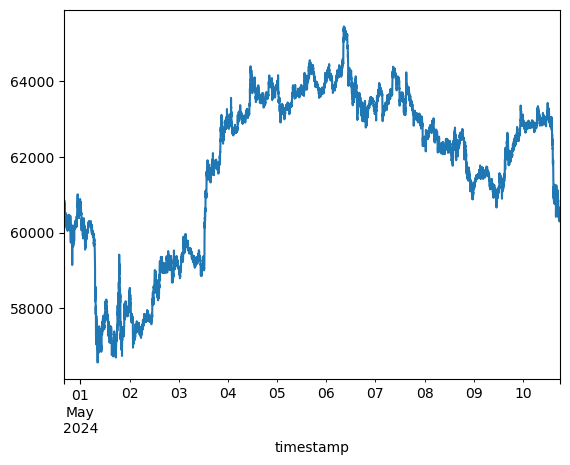

In [24]:
def get_last_timestamp(df):
    
    return int(df.timestamp[-1:].values[0])

def format_data(response):
    
    data = pd.DataFrame(response, columns =['timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'])
    f = lambda x: dt.datetime.utcfromtimestamp(int(x)/1000)
    data.index = data.timestamp.apply(f)
    return data[::-1].apply(pd.to_numeric)

def download_as_pd(symbol, interval, start, end):
    df = pd.DataFrame()
    while True:
        response = session.get_kline(category='linear', 
                                     symbol=symbol, 
                                     start=start,
                                     interval=interval,
                                     timeout=30).get('result').get('list')
        
        latest = format_data(response)
        start = get_last_timestamp(latest)
        time.sleep(0.1)
        df = pd.concat([df, latest])
        if start > end: break
    df.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)
    return df

def normalization(data):
    data = np.array(data)
    mean = np.mean(data)
    std = np.std(data)
    batch_normalized_data = (data-mean)/std
    return batch_normalized_data

df_BTC = download_as_pd("BTCUSDT", 1, int(dt.datetime(2024, 5, 1).timestamp()* 1000), int(dt.datetime(2024, 5, 11).timestamp()* 1000))
print(df_BTC)
target = df_BTC['close']
target_mean = np.mean(np.array(target))
target_std = np.std(np.array(target))
standardized_target = normalization(df_BTC['close'])
target.plot()

In [25]:
cryptos_list = ["ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT", "DOGEUSDT", "TONUSDT", "ADAUSDT", "SHIB1000USDT", "AVAXUSDT", "TRXUSDT", "DOTUSDT", "BCHUSDT", "LINKUSDT", "NEARUSDT", "MATICUSDT", "LTCUSDT", "ICPUSDT", "HNTUSDT", "UNIUSDT", "ETCUSDT", "APTUSDT", "HBARUSDT", "CROUSDT", "STXUSDT", "MNTUSDT", "XLMUSDT", "FILUSDT", "ATOMUSDT", "1000PEPEUSDT", "BANDUSDT"]
datas = [] #size: n*T
standardized_datas = []
for crypto in cryptos_list:
    seq = download_as_pd(crypto, 1, int(dt.datetime(2024, 5, 1).timestamp()* 1000), int(dt.datetime(2024, 5, 11).timestamp()* 1000))
    print(crypto)
    print(seq['close'])
    datas.append(seq['close'])
    standardized_datas.append(normalization(seq['close']))

ETHUSDT
timestamp
2024-04-30 16:00:00    2993.61
2024-04-30 16:01:00    2986.40
2024-04-30 16:02:00    2984.29
2024-04-30 16:03:00    2991.70
2024-04-30 16:04:00    2996.35
                        ...   
2024-05-10 18:03:00    2891.54
2024-05-10 18:04:00    2890.20
2024-05-10 18:05:00    2887.86
2024-05-10 18:06:00    2893.87
2024-05-10 18:07:00    2894.08
Name: close, Length: 14528, dtype: float64
BNBUSDT
timestamp
2024-04-30 16:00:00    558.90
2024-04-30 16:01:00    557.80
2024-04-30 16:02:00    559.30
2024-04-30 16:03:00    560.50
2024-04-30 16:04:00    562.40
                        ...  
2024-05-10 18:03:00    584.80
2024-05-10 18:04:00    584.80
2024-05-10 18:05:00    584.35
2024-05-10 18:06:00    585.20
2024-05-10 18:07:00    585.40
Name: close, Length: 14528, dtype: float64
SOLUSDT
timestamp
2024-04-30 16:00:00    127.44
2024-04-30 16:01:00    126.74
2024-04-30 16:02:00    126.38
2024-04-30 16:03:00    126.54
2024-04-30 16:04:00    127.00
                        ...  
2024-05-1

In [26]:
def dataloader_X(X, batch_size, window_size):
    # X: numpy(input_size, T)
    data = torch.tensor([X.T[i:i+window_size].T for i in range(X.shape[1]-window_size+1)], dtype=torch.float, requires_grad=True)
    datas = []
    for i in range(X.shape[1]//batch_size+1):
        if i == X.shape[1]//batch_size:
            datas.append(data[i*batch_size:])
        else:
            datas.append(data[i*batch_size:(i+1)*batch_size])
    if window_size == 1:
        datas = [data.view((data.size()[0],1)) for data in datas]
    return datas

def dataloader_Y(Y, batch_size, window_size):
    # Y: numpy(T)
    data = torch.tensor([Y[i:i+window_size] for i in range(Y.shape[0]-window_size+1)], dtype=torch.float, requires_grad=True)
    datas = []
    for i in range(Y.shape[0]//batch_size+1):
        if i == Y.shape[0]//batch_size:
            datas.append(data[i*batch_size:])
        else:
            datas.append(data[i*batch_size:(i+1)*batch_size])
    if window_size == 1:
        datas = [data.view((data.size()[0],1)) for data in datas]
    return datas

def dataloader_Z(Z, batch_size, window_size):
    # Z: numpy(T)
    data = torch.tensor([Z[i:i+window_size] for i in range(Z.shape[0]-window_size+1)], dtype=torch.float, requires_grad=True)
    datas = []
    for i in range((Z.shape[0] // batch_size) + 1):
        if i == Z.shape[0] // batch_size:
            datas.append(data[i*batch_size:])
        else:
            datas.append(data[i*batch_size:(i+1)*batch_size])
    datas = [data.view(data.size()[0],1) for data in datas]
    return datas
    
window_size = 10
batch_size = 128
input_size = np.array(datas).shape[0]
T = np.array(datas).shape[1]

# Datas size: n*T
X = np.array(standardized_datas)
Y = np.array(standardized_target)
Z = np.array(target[window_size:])

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

# train_day+validation_day+test_day = T-1-window_size
train_day = int(T*train_ratio)
validation_day = int(T*validation_ratio)
test_day = int(T*test_ratio)

X_train_data = dataloader_X(X.T[:train_day].T,batch_size,window_size)
X_validation_data = dataloader_X(X.T[train_day-window_size+1:train_day+validation_day].T,batch_size,window_size)
X_test_data = dataloader_X(X.T[train_day+validation_day-window_size+1:train_day+validation_day+test_day].T,batch_size,window_size)

Y_train_data = dataloader_Y(Y[:train_day],batch_size,window_size)
Y_validation_data = dataloader_Y(Y[train_day-window_size+1:train_day+validation_day],batch_size,window_size)
Y_test_data = dataloader_Y(Y[train_day+validation_day-window_size+1:train_day+validation_day+test_day],batch_size,window_size)

labels_train_data = dataloader_Z(Z[:train_day-window_size+1],batch_size,1)
labels_validation_data = dataloader_Z(Z[train_day-window_size+1:train_day+validation_day-window_size+1], batch_size,1)
labels_test_data = dataloader_Z(Z[train_day+validation_day-window_size+1:train_day+validation_day+test_day-window_size+1],batch_size,1)

print("train_day:",train_day)
print("validation_day:",validation_day)
print("test_day:",test_day)
print("====================")
print("Shape of Each Input")
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Z.shape:", Z.shape)
print("====================")
print("Training Data")
print(len(X_train_data))
print(X_train_data[-1].size())
print(len(Y_train_data))
print(Y_train_data[-1].size())
print(len(labels_train_data))
print(labels_train_data[-1].size())
print("====================")
print("Validation Data")
print(len(X_validation_data))
print(X_validation_data[-1].size())
print(len(Y_validation_data))
print(Y_validation_data[-1].size())
print(len(labels_validation_data))
print(labels_validation_data[-1].size())
print("====================")
print("Test Data")
print(len(X_test_data))
print(X_test_data[-1].size())
print(len(Y_test_data))
print(Y_test_data[-1].size())
print(len(labels_test_data))
print(labels_test_data[-1].size())

train_day: 10169
validation_day: 2179
test_day: 2179
Shape of Each Input
X.shape: (30, 14528)
Y.shape: (14528,)
Z.shape: (14518,)
Training Data
80
torch.Size([48, 30, 10])
80
torch.Size([48, 10])
80
torch.Size([48, 1])
Validation Data
18
torch.Size([3, 30, 10])
18
torch.Size([3, 10])
18
torch.Size([3, 1])
Test Data
18
torch.Size([3, 30, 10])
18
torch.Size([3, 10])
18
torch.Size([3, 1])


## Model Training

In [27]:
def trian(model, X_train_data, Y_train_data, labels_train_data, X_validation_data, Y_validation_data, labels_validation_data, criterion, optimizer, epoch_scheduler, epoches):
    
    hist_train_losses = []
    hist_validation_losses = []
    test = []
    
    for epoch in range(epoches):
        
        # Training training
        model.train()
        train_losses = []
        
        for batch_x, batch_y, label in zip(X_train_data, Y_train_data, labels_train_data):
            output = torch.zeros(batch_x.size(0)).to(device)
            for i in range(batch_x.size(0)):
                output[i] = model(batch_x[i].to(device), batch_y[i].to(device))
            train_loss = criterion(output.unsqueeze(1).to(device), label.to(device))
            train_losses.append(train_loss.cpu().detach().numpy())
            test.append(train_loss.cpu().detach().numpy())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
        hist_train_losses.append(np.mean(train_losses))
        
        # Validation training
        model.eval()
        Validation_outputs = []
        
        for batch_x, batch_y in zip(X_validation_data, Y_validation_data):
            for data_x, data_y in zip(batch_x, batch_y):
                Validation_outputs.append(model(data_x.to(device), data_y.to(device)).cpu().detach().float())
        validation_loss = criterion(torch.tensor(Validation_outputs, dtype=torch.float).to(device), torch.tensor(Z[train_day-window_size+1:train_day+validation_day-window_size+1]).unsqueeze(1).to(device))
        hist_validation_losses.append(validation_loss.cpu().detach().numpy())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epoches}], Train Loss: {hist_train_losses[epoch]:.8f}, Validation Loss: {hist_validation_losses[epoch]:.8f}')
            
        epoch_scheduler.step()
    
    plt.figure(figsize=(10, 6))
    plt.plot(hist_train_losses,label='Train Loss')
    plt.plot(hist_validation_losses,label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoches')
    plt.ylabel('Loss') 
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6)) 
    plt.plot(Validation_outputs,label='Predict')
    plt.plot(Z[train_day-window_size+1:train_day+validation_day-window_size+1],label='Target')
    plt.title('Prediction')
    plt.xlabel('Time')
    plt.ylabel('Closed price') 
    
    lables = df_BTC.index[train_day-window_size+1+1:train_day+validation_day-window_size+1+1]
    step = 800
    ticks = range(0,validation_day,step)
    plt.xticks(ticks,lables[ticks])
    plt.legend()
    plt.show()


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2179, 1])) that is different to the input size (torch.Size([2179])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/130], Train Loss: 398799.03125000, Validation Loss: 2184248.56911372
Epoch [20/130], Train Loss: 65896.32812500, Validation Loss: 920649.45557177
Epoch [30/130], Train Loss: 14307.95019531, Validation Loss: 758672.40965541
Epoch [40/130], Train Loss: 6400.70214844, Validation Loss: 670651.50138337
Epoch [50/130], Train Loss: 8116.63183594, Validation Loss: 692032.19140182
Epoch [60/130], Train Loss: 11276.28906250, Validation Loss: 791499.70613630
Epoch [70/130], Train Loss: 6853.82275391, Validation Loss: 701995.32412715
Epoch [80/130], Train Loss: 4545.63378906, Validation Loss: 657723.02864535
Epoch [90/130], Train Loss: 4069.93823242, Validation Loss: 662634.98301253
Epoch [100/130], Train Loss: 4568.31494141, Validation Loss: 658677.70744753
Epoch [110/130], Train Loss: 3809.64135742, Validation Loss: 668149.03247149
Epoch [120/130], Train Loss: 3417.95190430, Validation Loss: 656192.76682351
Epoch [130/130], Train Loss: 3358.88354492, Validation Loss: 653772.66759277


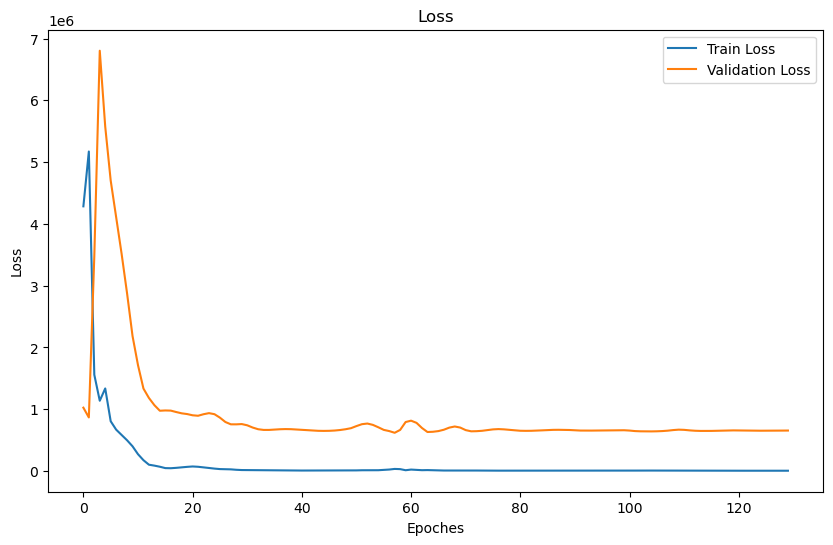

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


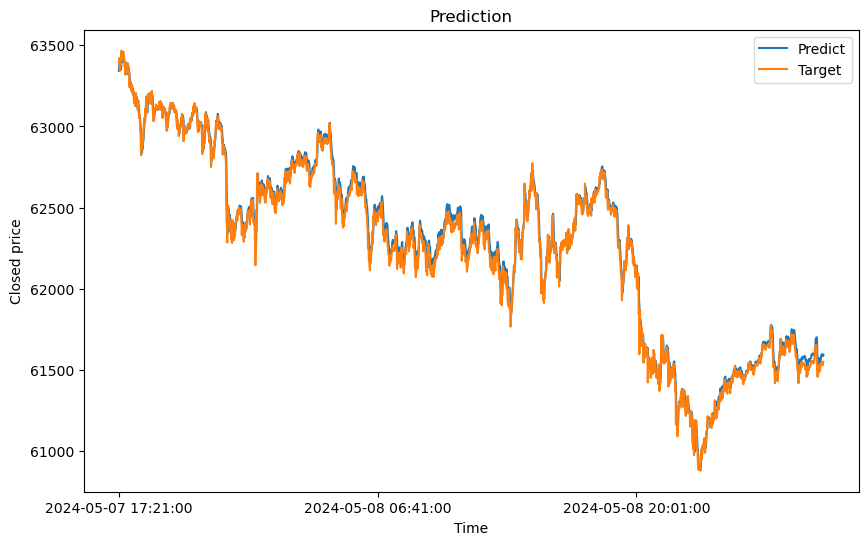

In [28]:
model = DA_RNN(target_mean,target_std).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.001)
epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
trian(model, X_train_data, Y_train_data, labels_train_data, X_validation_data, Y_validation_data, labels_validation_data, criterion, optimizer, epoch_scheduler, epoches=130)

## Result

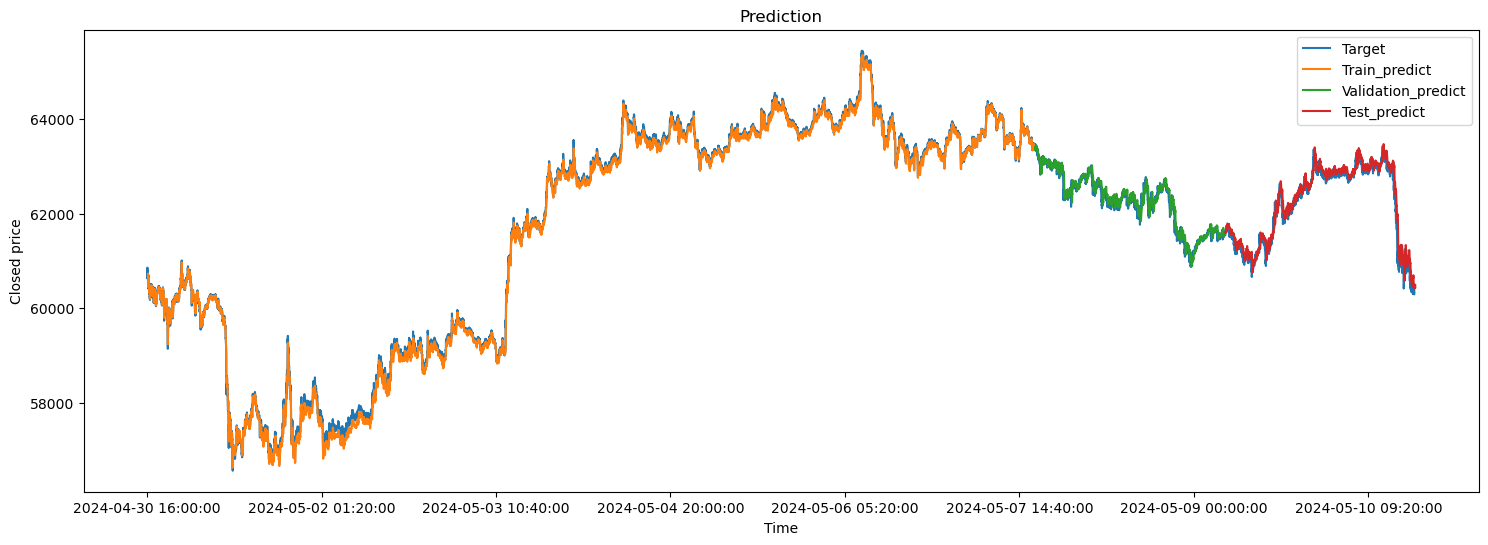

In [29]:
model.eval()
pred_list = []
for i in range(train_day):
    output = model(torch.tensor(X[:,i:i+window_size], dtype=torch.float),torch.tensor(Y[i:i+window_size], dtype=torch.float))
    pred_list.append(output.detach().numpy())
for i in range(validation_day):
    output = model(torch.tensor(X[:,train_day-window_size +1+i:train_day-window_size+1+i+window_size], dtype=torch.float),torch.tensor(Y[train_day-window_size+1+i:train_day-window_size+1+i+window_size], dtype=torch.float))
    pred_list.append(output.detach().numpy())
for i in range(test_day):
    output = model(torch.tensor(X[:,train_day+validation_day-window_size+1+i:train_day+validation_day-window_size+1+i+window_size], dtype=torch.float),torch.tensor(Y[train_day+validation_day-window_size+1+i:train_day+validation_day-window_size+1+i+window_size], dtype=torch.float))
    pred_list.append(output.detach().numpy())

plt.figure(figsize=(18,6))
plt.plot(range(train_day+validation_day+test_day),target_std*Y[:train_day+validation_day+test_day]+target_mean,label='Target')
plt.plot(range(window_size,len(pred_list[:train_day])+window_size),pred_list[:train_day],label='Train_predict')
plt.plot(range(window_size+train_day,len(pred_list[train_day-1:train_day+validation_day])+window_size+train_day),pred_list[train_day-1:train_day+validation_day],label='Validation_predict')
plt.plot(range(window_size+train_day+validation_day,len(pred_list[train_day+validation_day-1:train_day+validation_day+test_day])+window_size+train_day+validation_day),pred_list[train_day+validation_day-1:train_day+validation_day+test_day],label='Test_predict')

lables = df_BTC.index
step = 2000
ticks = range(0,train_day+validation_day+test_day,step)

plt.xticks(ticks,lables[ticks])
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Closed price')
plt.legend()
plt.show()


## Reference

[R1] A Dual-Stage Attention-Based Recurrent Neural Network for Time Series Prediction [https://arxiv.org/pdf/1704.02971.pdf]\
[R2] Trading with the Momentum Transformer: An Intelligent and Interpretable Architecture [https://arxiv.org/pdf/2112.08534]\
[R3] Attention Is All You Need [https://arxiv.org/pdf/1706.03762]
